<a href="https://colab.research.google.com/github/marcellinusc/production-oil-rate-prediction/blob/master/rnn-model-v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [23]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/marcellinusc/production-oil-rate-prediction/master/XM-18.csv \
    -O /content/XM-18.csv

--2020-06-23 09:28:34--  https://raw.githubusercontent.com/marcellinusc/production-oil-rate-prediction/master/XM-18.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142394 (139K) [text/plain]
Saving to: ‘/content/XM-18.csv’

/content/XM-18.csv  100%[===================>] 139.06K  --.-KB/s    in 0.02s   

2020-06-23 09:28:35 (8.48 MB/s) - ‘/content/XM-18.csv’ saved [142394/142394]



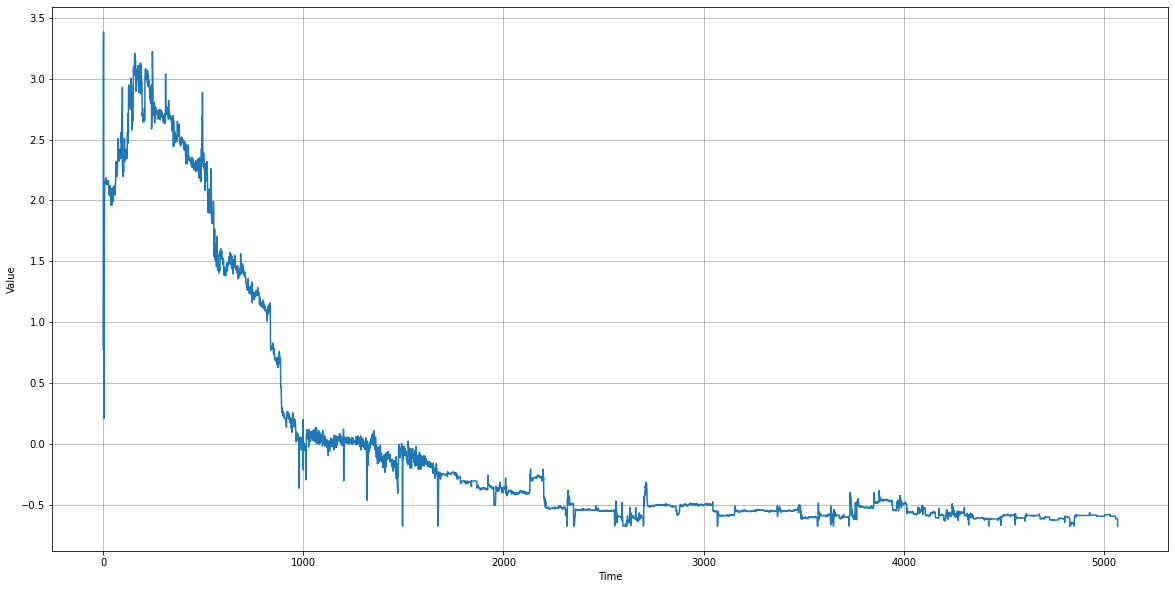

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/XM-18.csv') as csvfile:
  # YOUR CODE HERE
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(20, 10))
plot_series(time, series)

In [6]:
split_time = 4500
time_train = time[2000:split_time] # YOUR CODE HERE
x_train = series[2000:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
from keras import backend

def rmspe(y_true, y_pred):
    sum = backend.sqrt(backend.mean(backend.square( (y_true - y_pred) /
          backend.clip(backend.abs(y_true),backend.epsilon(),None) ), axis=-1) )
    return sum*100

Using TensorFlow backend.


In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 49ms/step - loss: 3.1065 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 50ms/step - loss: 2.8454 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 50ms/step - loss: 2.4727 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 48ms/step - loss: 2.0736 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 47ms/step - loss: 1.6762 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 50ms/step - loss: 1.2598 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 48ms/step - loss: 0.8507 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 52ms/step - loss: 0.5638 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 1s 52ms/step - loss: 0.4459 - lr: 2.5119e-08
Epoch 10/100
10/

(1e-08, 0.0001, 0.0, 2.0)

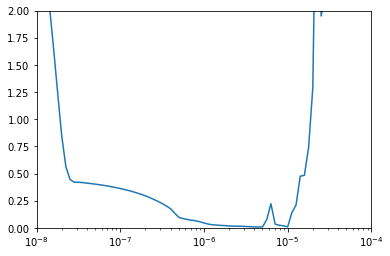

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 2])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9) # YOUR CODE HERE
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape", rmspe])
history = model.fit(train_set,epochs=500) # YOUR CODE HERE

# EXPECTED OUTPUT 
# You should see an MAE of <2 within about 30 epochs

Epoch 1/500
25/25 [==============================] - 1s 31ms/step - loss: 0.0282 - mape: 35.6132 - rmspe: 35.6132
Epoch 2/500
25/25 [==============================] - 1s 32ms/step - loss: 0.0077 - mape: 17.4881 - rmspe: 17.4881
Epoch 3/500
25/25 [==============================] - 1s 32ms/step - loss: 0.0049 - mape: 13.8740 - rmspe: 13.8740
Epoch 4/500
25/25 [==============================] - 1s 31ms/step - loss: 0.0036 - mape: 12.1518 - rmspe: 12.1518
Epoch 5/500
25/25 [==============================] - 1s 32ms/step - loss: 0.0026 - mape: 10.2698 - rmspe: 10.2698
Epoch 6/500
25/25 [==============================] - 1s 31ms/step - loss: 0.0021 - mape: 9.3019 - rmspe: 9.3019
Epoch 7/500
25/25 [==============================] - 1s 31ms/step - loss: 0.0018 - mape: 8.7141 - rmspe: 8.7141
Epoch 8/500
25/25 [==============================] - 1s 31ms/step - loss: 0.0016 - mape: 8.0384 - rmspe: 8.0384
Epoch 9/500
25/25 [==============================] - 1s 32ms/step - loss: 0.0014 - mape: 7.592

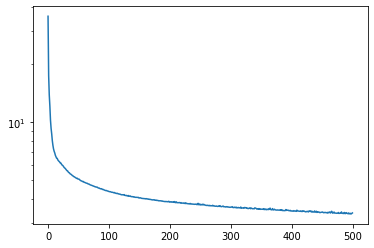

In [13]:
plt.semilogy(history.epoch, history.history["mape"])

In [14]:
#@title Save model as protobuf data format

model.save("saved_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/assets


In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

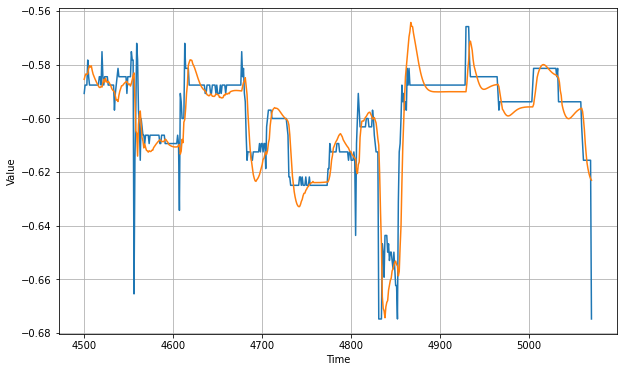

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT
# Plot should show projections following original data closely

In [22]:
def rmspe_pred(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

print("mape prediction:", tf.keras.metrics.mape(x_valid, rnn_forecast).numpy())
print("rmse prediction:", rmspe_pred(x_valid, rnn_forecast))

mape prediction: 0.96853226
rmse prediction: 1.6106327045779294


In [20]:
print(rnn_forecast)

# EXPECTED OUTPUT 
# Array of values in the low teens

[-0.58546233 -0.5841499  -0.5834391  -0.5836322  -0.58330595 -0.5814478
 -0.58036196 -0.5808905  -0.58043236 -0.58216864 -0.5835182  -0.58438724
 -0.58519393 -0.58595854 -0.5866839  -0.5873544  -0.5879586  -0.58848
 -0.58849007 -0.58816236 -0.58834386 -0.58660984 -0.58547276 -0.5865476
 -0.58505833 -0.5862315  -0.586667   -0.58620423 -0.5866203  -0.5873405
 -0.5879554  -0.5889519  -0.5894391  -0.5898469  -0.5901804  -0.5917713
 -0.59319323 -0.5931525  -0.5937391  -0.591467   -0.58992046 -0.58888614
 -0.5878808  -0.5878294  -0.5873937  -0.58699316 -0.58664584 -0.58638257
 -0.5862006  -0.58697134 -0.58745825 -0.58718026 -0.587953   -0.58700925
 -0.58563733 -0.5839833  -0.58307153 -0.59311736 -0.60466397 -0.6055532
 -0.6140764  -0.6022205  -0.59873897 -0.59727544 -0.60214764 -0.6071346
 -0.6083724  -0.61102396 -0.60954773 -0.6108797  -0.6119627  -0.6121017
 -0.61259997 -0.6120862  -0.6123513  -0.6123536  -0.61189336 -0.6118865
 -0.6109531  -0.6104499  -0.60996544 -0.6095113  -0.60908115 -